In [1]:
import numpy as np
import pandas as pd
import sys
import os
import re
import csv
import collections as co
import itertools as it
import umap
import hdbscan
import time 
import progressbar
import math
import random
import fileinput

import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import scipy.spatial.distance as ssd
import seaborn as sns

from Bio import Align, AlignIO, Phylo
from Bio.Align.Applications import MafftCommandline
from Bio.Seq import Seq 
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor, DistanceMatrix, DistanceCalculator
from ete3 import PhyloTree, Tree, faces, AttrFace, CircleFace, TreeStyle, NodeStyle, TextFace, SequenceFace
from IPython.display import display
from matplotlib import colors 
from scipy.cluster import hierarchy
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from statistics import mean
from scipy import stats
from kneed import DataGenerator, KneeLocator

In [2]:
class frequency(object):
    
    def __init__(self, k = 7, convert = 0):
    
        self.k = k
        self.convert = convert
        self.exist = co.defaultdict(int) 
        self.keys = list(self.exist.keys())
        self.col = len(self.keys)
        self.row = 0
        self.matrix = np.empty((self.row, self.col, ),dtype = "float64")
        self.amino = co.defaultdict(str, {
            'AAA':'K', 'AAC':'N', 'AAG':'K', 'AAT':'N',
            'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
            'AGA':'R', 'AGC':'S', 'AGG':'R', 'AGT':'S',
            'ATA':'I', 'ATC':'I', 'ATG':'M', 'ATT':'I',
            'CAA':'Q', 'CAC':'H', 'CAG':'Q', 'CAT':'H',
            'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
            'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
            'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
            'GAA':'E', 'GAC':'D', 'GAG':'E', 'GAT':'D',
            'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
            'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
            'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',    
            'TAA':'Y', 'TAC':'*', 'TAG':'*', 'TAT':'Y',
            'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
            'TGA':'*', 'TGC':'C', 'TGG':'W', 'TGT':'C',
            'TTA':'L', 'TTC':'F', 'TTG':'L', 'TTT':'F'
        })
                
    def translate(self, read):
    
        chain = ''

        for i in range(len(read) - 2):
            trip = read[i:i+3]
            chain += self.amino[trip]

        return(chain)
    
    
    def adjust_to_data(self, infile):
    
        self.row = infile.shape[0]
            
        for line, read in infile.itertuples(index=True, name=None):

            if self.convert == 1:
                seq = self.translate(read)
                del read

                num = len(seq) - self.k + 1

                for i in range(num):
                    kmer = seq[i:i+self.k]
                    self.exist[kmer] = 0

            else:
                seq = read
                del read

                num = len(seq) - self.k + 1

                if re.match('^[ACGT]*$', seq): 
                    for i in range(num):
                        kmer = seq[i:i+self.k]
                        self.exist[kmer] = 0
                else:
                    for i in range(num):
                        kmer = seq[i:i+self.k]
                        if re.match('^[ACGT]*$', kmer): 
                            self.exist[kmer] = 0
            
        self.keys = list(self.exist.keys())
        self.col = len(self.keys)
        self.matrix = np.empty((self.row, self.col, ), dtype="float64")
        
        del seq
    
    
    def calculate_frequence(self, infile):
        
        for line, read in infile.itertuples(index=True, name=None): 
                 
            if self.convert == 1:
                seq = self.translate(read)
                del read

                counts = self.exist.copy()
                num = len(seq) - self.k + 1

                for i in range(num):
                    kmer = seq[i:i+self.k]
                    counts[kmer] += 1

            else:
                seq = read
                del read

                counts = self.exist.copy()
                num = len(seq) - self.k + 1

                if re.match('^[ACGT]*$', seq): 
                    for i in range(num):
                        kmer = seq[i:i+self.k]
                        counts[kmer] += 1
                else:
                    for i in range(num):
                        kmer = seq[i:i+self.k]
                        if re.match('^[ACGT]*$', kmer): 
                            counts[kmer] += 1

            vector = np.array(list(counts.values()), dtype = "float64")

            self.matrix[line] = vector/vector.sum()
            
            counts.clear()
            del vector
            del seq
            del counts
    
    
    def get_keys(self):
        
        return(self.keys)
    
    def get_matrix(self):
        
        return(self.matrix)


# In[3]:


def subsplit(subtype):
    if re.match('^[H][0-9]+N[0-9]+$', subtype): 
        H = re.search('[H][0-9]+', subtype).group(0)
        N = re.search('[N][0-9]+', subtype).group(0)
    else:
        H = ''#np.nan
        N = ''#np.nan
    return(H, N)


# In[4]:


def convert_fasta(infile, outfile):

    #with some help from https://stackoverflow.com/questions/50856538/how-to-convert-multiline-fasta-files-to-singleline-fasta-files-without-biopython
    
    with open(infile) as f_input, open(outfile, 'w') as f_output:

        block = []

        for line in f_input:
    
            if line.startswith('>'):

                if block:
                    f_output.write(new_line + ',' + "".join(block) + '\n')
                    block = []
                
                new_line = line.strip().replace('|', ',')
            else:
                block.append(line.strip())
    
        if block:
            f_output.write(new_line + ',' + "".join(block) + '\n')


# In[5]:


def get_vectors(sequence, accession, metric, neigh, comp, pca):

    freq = frequency(k = 7, convert = 0)
    freq.adjust_to_data(sequence)
    freq.calculate_frequence(sequence)

    #Kevins approach
    #freq = frequency(k = 7)
    #freq.calculate_frequence(sequence)
    
    if pca:
        matrix = freq.get_matrix()
        pca_init = PCA(n_components=pca)
        pca_matr = pca_init.fit_transform(matrix)
        explained_var = pca_init.explained_variance_ratio_.sum()
        #pca_matr = freq.get_matrix()

        dataframe_pca = pd.concat([accession, pd.DataFrame(pca_matr)], axis=1, copy = False, ignore_index = False).set_index('accession')
    else:
        pca_matr = freq.get_matrix()
        dataframe_pca = pd.DataFrame()
        explained_var = -1
    
    
    if (pca and not comp) or (pca <= comp):
        reduced = pca_matr

    elif neigh and comp:
        reduced = umap.UMAP(
            n_neighbors = neigh,
            min_dist = 0.0,
            n_components = comp,
            random_state = 42,
            #metric = 'euclidean',
        ).fit_transform(pca_matr)
        
    else:
        reduced = pca_matr
    
    #approximation of cosine by l2 normalization (https://github.com/scikit-learn-contrib/hdbscan/issues/69)
    if metric == 'cosine':
        cos_red = normalize(reduced, norm='l2')
        dataframe = pd.concat([accession, pd.DataFrame(cos_red)], axis=1, copy = False, ignore_index = False).set_index('accession')
    else:
        dataframe = pd.concat([accession, pd.DataFrame(reduced)], axis=1, copy = False, ignore_index = False).set_index('accession')
    
    return(dataframe, dataframe_pca, explained_var)


# In[6]:


def get_elbow(dataframe, extra, accession, metric, min_clust, sample, kneedle):
    
    #with some help from https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
    
    if metric == 'cosine':
        metric = 'euclidean'
    
    clusterer_best = hdbscan.HDBSCAN(
        min_samples = sample,
        min_cluster_size = min_clust,
        gen_min_span_tree = True,
        metric = metric,
    ).fit(dataframe)
    
    label = clusterer_best.labels_
    label_list = label.tolist()
    
    if -1 in label_list:
        label_list.remove(-1)
    
    n_cluster = len(set(label_list))
    
    linkage = clusterer_best.single_linkage_tree_.to_pandas()
    numpy_linkage = linkage.drop(columns=['parent']).to_numpy()
    
    dist = numpy_linkage[:, 2]
    dist_rev = dist[::-1]
    
    if kneedle == -1:
        dist_area = dist_rev[0:n_cluster]
    else:
        dist_area = dist_rev[0:kneedle]
    
    idxs = np.arange(1, len(dist_area) + 1)

    kn = KneeLocator(idxs, dist_area,
        curve='convex',
        direction='decreasing',
        interp_method='polynomial',
        online=True,
        S = 1.0,
    )
    
    n_cluster_raw = kn.knee
    n_cluster_norm = kn.norm_knee
    
    #linkage.set_index('parent', inplace = True)
    elbow = pd.DataFrame({'n_cluster': idxs, 
                          'distance': dist_area, 
                          'x_normalized':kn.x_normalized, 
                          'y_normalized':kn.y_normalized, 
                          'x_difference':kn.x_difference, 
                          'y_difference':kn.y_difference}).set_index('n_cluster')
    epsilon_best = elbow.loc[n_cluster_raw][['distance']].item()
    linkage.set_index('parent', inplace = True)
    
    return(linkage, elbow, epsilon_best, n_cluster_raw, n_cluster_norm)


# In[7]:


def get_cluster(epsilon_best, dataframe, extra, accession, metric, min_clust, sample):
    
    #approximation see above
    if metric == 'cosine':
        metric = 'euclidean'
    
    clusterer_best = hdbscan.HDBSCAN(
        min_samples = sample,
        min_cluster_size = min_clust,
        cluster_selection_epsilon = epsilon_best,
        gen_min_span_tree=True,
        metric = metric,
    ).fit(dataframe)

    label = clusterer_best.labels_
    label_list = label.tolist()
    
    unclustered = label_list.count(-1)
    if -1 in label_list:
        label_list.remove(-1)
    
    n_cluster = len(set(label_list))
    
    cluster = pd.concat([pd.DataFrame(label, columns = ['cluster']), extra, accession], axis=1, copy = False).set_index('accession')
    #linkage = clusterer_best.single_linkage_tree_.to_pandas()
    #linkage.set_index('parent', inplace = True)
    
    N_unmatch = cluster.query('cluster != -1').groupby('cluster').filter(lambda x: x['N'].replace('', np.nan).nunique() > 1).cluster.nunique()
    H_unmatch = cluster.query('cluster != -1').groupby('cluster').filter(lambda x: x['H'].replace('', np.nan).nunique() > 1).cluster.nunique() 
    
    cluster.insert(2, 'centroid', False)

    num = cluster['cluster'].max()+1
    values = [True]*num
    accessions = []

    for i in range(num):

        query = cluster.query('cluster == @i')
        match = query.index.values.tolist()
        sub = dataframe.loc[match]

        if not sub.empty:

            tuple_min = (0, '')
            for name, row in sub.iterrows():

                if not tuple_min[1]:
                    dist_min = ssd.cdist([row], sub, metric).mean()
                    tuple_min = (dist_min, name)
                else:
                    dist_min = ssd.cdist([row], sub, metric).mean()
                    if dist_min < tuple_min[0]:
                        tuple_min = (dist_min, name)

            accessions.append(tuple_min[1])

    cluster.update(pd.DataFrame(values, columns=['centroid'], index = accessions))
    
    return(cluster, n_cluster, unclustered, H_unmatch, N_unmatch)


# In[8]:


def plot_density(density, segments, outpath, render, accuracy, suffix = ''):

    for seg in segments:
             
        with sns.axes_style("darkgrid"):
            fig, ax = plt.subplots(figsize=(4,4))
            sns.histplot(data = density.query('segment == 4'), x = "size", kde=False, log_scale=False, element="step", fill = True, bins = round(density.query('segment == 4')['size'].max()*accuracy), ax = ax)
            plt.xlabel("log(Count)")
            plt.ylabel("#Cluster")
            plt.tight_layout()
            plt.close(fig)
            fig.savefig(outpath + 'Cluster_Distribution_Segment_' + str(seg) + str(suffix) + '.' + render)
    
        with sns.axes_style("darkgrid"):
            fig, ax = plt.subplots(figsize=(4,4))
            sns.histplot(data = density.query('segment == 4'), x = "size", kde=False, log_scale=True, element="step", fill = True, bins = round(density.query('segment == 4')['size'].max()*accuracy), ax = ax)
            plt.xlabel("log(Count)")
            plt.ylabel("#Cluster")
            plt.tight_layout()
            plt.close(fig)
            fig.savefig(outpath + 'Cluster_Distribution_Log_Segment_' + str(seg) + str(suffix) + '.' + render)

# In[9]:


def plot_elbow(elbow, information, segments, outfolder, render, suffix = ''):

        
    for seg in segments:
    
        with sns.axes_style("darkgrid"):
            fig, ax = plt.subplots(figsize=(4,4))
        
            sns.lineplot(data = elbow.query('segment == @seg'), x = "n_cluster", y = "distance", ax = ax)

            y_max = elbow.query('segment == @seg')['distance'].max().item()
            x_max = elbow.query('segment == @seg')['n_cluster'].max().item()

            y_note = information.query('segment == @seg')['epsilon'].item()
            x_note = information.query('segment == @seg')['n_cluster_raw'].item()
            z_note = information.query('segment == @seg')['n_cluster'].item()

            ax.axhline(y = y_note, alpha=1, color="y", label = f"Distance = {y_note:0.3f}")
            ax.axvline(x = x_note, alpha=1, color="r", label = f"#Cluster = {x_note:0.0f}")
            ax.axvline(x = z_note, alpha=1, color="g", label = f"#Cluster = {z_note:0.0f}")

            #ax.text(x_max, y_note, f"{y_note:0.3f}", va='bottom', ha='right', color = "r", alpha=1, size=10)
            #ax.text(x_note, y_max, f"{x_note:0.0f}", rotation='vertical', va='top', ha='left', color = "r", alpha=1, size=10)
            #ax.text(z_note, y_max, f"{z_note:0.0f}", rotation='vertical', va='top', ha='right', color = "g", alpha=1, size=10)

            plt.xlabel("#Cluster")
            plt.ylabel("Distance")
        
            plt.legend()
            plt.tight_layout()
            plt.close(fig)
            fig.savefig(outfolder + 'Cluster_Elbow_Knee_Segment_' + str(seg) + str(suffix) + '.' + render)

        
        with sns.axes_style("darkgrid"):
            fig, ax = plt.subplots(figsize=(4,4))
        
            sns.lineplot(data = elbow.query('segment == @seg'), x = "x_normalized", y = "y_normalized", ax = ax)
            sns.lineplot(data = elbow.query('segment == @seg'), x = "x_difference", y = "y_difference", color="g", ax = ax)
        
            z_note = information.query('segment == @seg')['n_cluster_norm'].item()
            ax.axvline(x = z_note, alpha=1, color="r", label = f"norm(#Cluster) = {z_note:0.3f}")
            #ax.text(z_note, y_max*0.0, f"{z_note:0.3f}", rotation='vertical', va='bottom', ha='left', color = "r", alpha=1, size=10)

            plt.xlabel("norm(#Cluster)")
            plt.ylabel("Difference")
        
            plt.legend()
            plt.tight_layout()
            plt.close(fig)
            fig.savefig(outfolder + 'Cluster_Knee_Segment_' + str(seg) + str(suffix) + '.' + render)


# In[10]:


#Modified Version of the code presented on https://github.com/scipy/scipy/issues/8274
def getNewick(node, newick, parentdist, leaf_names):
    
    if node.is_leaf():
        return(leaf_names[node.id] + ":" + np.format_float_positional(parentdist - node.dist) + newick)
        #return "%s:%.5f%s" % (leaf_names[node.id], parentdist - node.dist, newick)
    
    else:
        if len(newick) > 0:
            newick = "):" + np.format_float_positional(parentdist - node.dist) + newick
            #newick = "):%.5f%s" % (parentdist - node.dist, newick)
        else:
            newick = ");"
        newick = getNewick(node.get_left(), newick, node.dist, leaf_names)
        newick = getNewick(node.get_right(), "," + newick, node.dist, leaf_names)
        #newick = getNewick(node.get_right(), ",%s" % (newick), node.dist, leaf_names)
        
        newick = "(" + newick
        #newick = "(%s" % (newick)
        return(newick)


# In[11]:


def alignment(fasta, threads, outfasta, outmsa, treeout):    

    fasta.to_csv(outfasta, header=None, index=True, sep='\n', mode='w')

    mafft_cline = MafftCommandline(input=outfasta, thread=threads,  treeout = treeout)
    #mafft_cline = MafftCommandline(input=outfasta, thread=threads,  treeout = False)
    stdout, stderr = mafft_cline()

    #os.remove('tmp.fasta') 
    with open(outmsa, "w") as handle:
        handle.write(stdout)
    
    return(stdout)


# In[12]:


def fill_gaps(group, protein):
    
    set_protein = set(group[protein].tolist())
    if '' in set_protein:
        set_protein.discard('')
    if len(set_protein) == 1:
        group['protein'] = list(set_protein)[0]
    else:
        group['protein'] = group[protein]
        group['protein'].replace('', 'mixed', inplace = True)
        group['protein'].fillna('mixed', inplace = True)
        
    return(group)


# In[13]:


def get_acc(dictionary_tree, list_value):
    list_accessions = []
    for key, value in dictionary_tree.items():
         if value in list_value:
            list_accessions.append(key)
    return(list_accessions)


# In[14]:


def layout(node):
    
    if node.is_leaf():
        N = AttrFace("name", fsize=10)
        faces.add_face_to_node(N, node, 0, position="aligned")
    
        M = AttrFace("size", fsize=10, text_prefix='|Size ', text_suffix='|')
        faces.add_face_to_node(M, node, 1, position="aligned")    


# In[15]:


def get_tree(cluster, upload, segment, prot, list_color_hex, list_prune = [], list_focus = [], collapse = True, path_phylo = '', msa_dict = co.defaultdict(str), area = [], linkage = pd.DataFrame()):

    if prot:
    #Dataframes Creation and Correction
        dataframe_tree_query = cluster.query('segment == @segment').join(upload.set_index('accession')[['host', 'date']])[['cluster', prot, 'host', 'date']]
        dataframe_tree_corr = dataframe_tree_query.groupby('cluster').apply(fill_gaps, protein = prot).drop(prot, axis = 1)
        dictionary_tree = dataframe_tree_corr.to_dict()
        list_tree_label = dataframe_tree_corr.index.values
    else:
        dataframe_tree_query = cluster.query('segment == @segment').join(upload.set_index('accession')[['host', 'date']])[['cluster', 'host', 'date']]
        dataframe_tree_query['protein'] = 'mixed'
        dictionary_tree = dataframe_tree_query.to_dict()
        list_tree_label = dataframe_tree_query.index.values
        
    #Tree Backbone Creation:
    tree_style = TreeStyle()
    
    if not path_phylo and not linkage.empty:
        array_tree_link = linkage.query('segment == @segment').drop(columns=['segment', 'parent']).to_numpy()
        tree_hierarchy = hierarchy.to_tree(array_tree_link, False)
        tree_newick = getNewick(tree_hierarchy, "", tree_hierarchy.dist, list_tree_label)
        tree = Tree(tree_newick)
    
    elif path_phylo and linkage.empty:    
        tree = Tree(path_phylo)
        for leaf in tree.iter_leaves():
            leaf_name = leaf.name.split('_')[1]
            if not leaf_name == 'Cluster':
                leaf.name = '>' + leaf_name
            else:
                leaf.name = leaf.name.split('_')[2]
                
    else:
        print('Linkage Tree and Phylo Tree both or none given. Empty Tree generated.')
        tree = Tree()
        return(tree, tree_style)
        
    #General Appereance Settings:
    for node in tree.traverse():
        node.img_style["vt_line_width"] = 1
        node.img_style["hz_line_width"] = 1
        node.img_style["vt_line_type"] = 0
        node.img_style["hz_line_type"] = 0
        node.img_style["fgcolor"] = "#000000"
        node.img_style["shape"] = "circle"
        node.img_style["vt_line_color"] = "#000000"
        node.img_style["hz_line_color"] = "#000000"
        node.img_style['bgcolor'] = 'lightgrey'
        node.protein = 'mixed'

    #List and Dictionary Creation
    #dict_color_protein = co.defaultdict(str)
    list_cluster = list(set(dictionary_tree['cluster'].values()))
    list_protein = list(set(dictionary_tree['protein'].values()))
    list_host = list(set(dictionary_tree['host'].values()))
    list_color = []
    list_cluster_existing = []
    
    #Initial Leaf Settings:
    for leaf in tree.iter_leaves():
        if leaf.name.startswith('>'):
            leaf.host = dictionary_tree['host'].get(leaf.name, "none")
            leaf.date = dictionary_tree['date'].get(leaf.name, "none")
            leaf.cluster = dictionary_tree['cluster'].get(leaf.name, "none")
            leaf.protein = dictionary_tree['protein'].get(leaf.name, "mixed")
            leaf.name = leaf.name[1:]
            leaf.accession = True
        else:
            leaf_member = get_acc(dictionary_tree['cluster'], [int(leaf.name)])
            leaf.protein = dictionary_tree['protein'].get(leaf_member[0], "mixed")
            leaf.size = len(leaf_member)
            leaf.accession = False
    
    #Cluster Node Creation and Settings:
    if -1 in list_cluster:
        list_cluster.remove(-1)
    
    for cluster in list_cluster:
        try:
            list_member = tree.search_nodes(cluster=cluster)
            node_cluster = tree.get_common_ancestor(list_member)
            node_cluster.name = str(cluster)
            node_cluster.accession = False
            node_cluster.size = len(list_member)
            list_cluster_existing.append(cluster)
        except:
            pass
            
    #Serotype Coloring (maybe include mixed in the coloring):
    if 'mixed' in list_protein:
        list_protein.remove('mixed')

    if prot:

        for protein in list_protein:

            for tree_protein in tree.get_monophyletic(values=[protein], target_attr = "protein"):

                color = list_color_hex[int(protein[1:])-1]
                #dict_color_protein[color] = protein
                #tree_protein.protein = protein
                #tree_protein.img_style['bgcolor'] = color

                for node_protein in tree_protein.traverse():

                    node_protein.img_style['bgcolor'] = color
                    node_protein.protein = protein

    #Host Monophyletic Lines Drawing:
    for host in list_host:
        for tree_host in tree.get_monophyletic(values=[host], target_attr = "host"):
            
            #tree_host.img_style["vt_line_type"] = 1
            #tree_host.img_style["hz_line_type"] = 1
            #tree_host.host = host
            
            for node_host in tree_host.traverse():
                node_host.img_style["vt_line_type"] = 1
                node_host.img_style["hz_line_type"] = 1
                node_host.host = host

    #Pruning according to Settings:
    if not list_prune:
        if not list_focus:
            if collapse == True:
                list_prune = list(map(str, list_cluster_existing))
        else:
            list_prune = [accession[1:] for accession in get_acc(dictionary_tree['cluster'], list_focus)]
            if collapse == False:
                list_prune.extend(list(map(str, list(set(list_cluster_existing).difference(set(list_focus))))))
    
    if list_prune:
        try:
            tree.prune(list_prune)
        except:
            print('No pruning performed.')

    for leaf in tree:
        if leaf.accession == True:
            leaf.add_face(AttrFace("cluster", fsize=10, text_prefix='Cluster: '), 0, position="aligned")
            leaf.add_face(AttrFace("name", fsize=10, text_prefix='|', text_suffix='|'), 1, position="aligned")
            leaf.add_face(AttrFace("date", fsize=10, text_prefix='Date: '), 2, position="aligned")
            if msa_dict:
                seq = msa_dict.get(leaf.name, "")
                if area:
                    area_seq = "...".join([seq[start:end] for start, end in area])
                    leaf.add_face(SequenceFace(area_seq), 3, position="aligned")
                else:
                    leaf.add_face(SequenceFace(seq), 3, position="aligned")
        else:
            leaf.add_face(AttrFace("name", fsize=10, text_prefix='Cluster: '), 0, position="aligned")
            leaf.add_face(AttrFace("size", fsize=10, text_prefix='|Size: ', text_suffix='|'), 1, position="aligned")
            if msa_dict:
                seq = msa_dict.get(leaf.name, "")
                if area:
                    area_seq = "...".join([seq[start:end] for start, end in area])
                    leaf.add_face(SequenceFace(area_seq), 2, position="aligned")
                else:
                    leaf.add_face(SequenceFace(seq), 2, position="aligned")
        
        list_color.append(leaf.img_style['bgcolor'])

    if prot:
        set_color = set(list_color)
        column = 0
        for color_hex in list_color_hex:
            if color_hex in set_color:
                face_protein = TextFace(prot + str(list_color_hex.index(color_hex)+1))
                face_protein.margin_top = 10
                face_protein.margin_right = 10
                face_protein.margin_left = 10
                face_protein.margin_bottom = 10
                face_protein.border.width = 1
                face_protein.background.color = color_hex
                tree_style.legend.add_face(face_protein, column=column)
                column += 1
        tree_style.legend_position = 1
            
    tree_style.show_leaf_name = False
    tree_style.draw_guiding_lines = True
    tree_style.guiding_lines_color = 'black'
    
    if not msa_dict:
        tree_style.mode = "c"

    return(tree, tree_style, tree_newick)


def pairmsa(nuc1, nuc2):
        
    seq1 = Seq(nuc1.item())
    seq2 = Seq(nuc2.item()) 

    aligner = Align.PairwiseAligner()
    alignments = aligner.align(seq1, seq2) 
    
    #alignments = pairwise2.align.globalmx(seq1, seq2, 1, -1) 
    
    return(alignments[0].score)

def sample_difference(cluster, genome, segment, tree, threshold = -1, n = -1, index = []):
    
    if not index:
        num = cluster['cluster'].max()+1
        index = [i for i in range(num)]
    else:
        num = len(index)
    
    pair = np.empty([num, num])
    
    for x, j in enumerate(index):
        for y, k in enumerate(index):
            
            if j != k:
                dist = tree.get_distance(str(j), str(k))
            else:
                dist = 0.0
            
            if threshold == -1 or dist <= threshold:
            
                if n == -1:
                    sample_x = cluster.query('segment == @segment & cluster == @j & centroid == True').join(genome)[['genome']]
                    sample_y = cluster.query('segment == @segment & cluster == @k & centroid == True').join(genome)[['genome']]

                else:
                    query_x = cluster.query('segment == @segment & cluster == @j').join(genome)[['genome']]
                    if len(query_x) >= n:
                        sample_x = query_x.sample(n=n, random_state=42)
                    else:
                        sample_x = query_x

                    query_y = cluster.query('segment == @segment & cluster == @k').join(genome)[['genome']]
                    if len(query_y) >= n:
                        sample_y = query_y.sample(n=n, random_state=42)
                    else:
                        sample_y = query_y

                dist = ssd.cdist(sample_x, sample_y, metric = pairmsa)

                dist_mean = pd.DataFrame(dist, dtype = 'float64').mean().mean()
                len_mean = (sample_x['genome'].str.len().mean() + sample_y['genome'].str.len().mean())/2
                
                pair[x,y] = dist_mean/len_mean
                
            else:
                pair[x,y] = 0.0
            
    dataframe_pair = pd.DataFrame(pair, index = index, columns = index)

    return(dataframe_pair)


def plot_difference(proof, segments, outpath, render):

    with sns.axes_style("darkgrid"):
        fig, ax = plt.subplots(figsize=(8,6))
        ax = sns.heatmap(proof, linewidths=.5)
        plt.xlabel("Cluster")
        plt.ylabel("Cluster")
        plt.tight_layout()
        plt.close(fig)
        fig.savefig(outpath + 'Cluster_Difference_Segment_' + str(segments) + '.' + render)

# In[23]:


def main(infile, outfolder, segments, custom, metric, min_clust, sample, umap_neigh, umap_comp, pca_comp, kneedle, render, epsilon):#, recreate):

    Hs = ['H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 'H17', 'H18']
    Ns = ['N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10', 'N11']
    tree_hex = ['#FF0029','#377EB8','#66A61E','#984EA3','#00D2D5','#FF7F00','#AF8D00','#7F80CD','#B3E900','#C42E60','#A65628','#F781BF','#8DD3C7','#BEBADA','#FB8072','#80B1D3','#FDB462','#FCCDE5']

    try:
        if not outfolder.endswith("/"):
            outfolder += "/"

        if not os.path.isdir(outfolder):
            os.mkdir(outfolder)

        #if recreate == True:
        for f in os.listdir(outfolder):
            os.remove(os.path.join(outfolder, f))
    except:
        sys.exit('Outfolder not reachable. Exit.')

    #Dict Creation
    dataframe_pca_dict = co.defaultdict(list)
    dataframe_dict = co.defaultdict(list)
    cluster_dict = co.defaultdict(list)
    information_dict = co.defaultdict(list)
    linkage_dict = co.defaultdict(list)
    elbow_dict = co.defaultdict(list)

    #Upload Fasta
    try:
        upload = pd.read_csv('fasta.csv', sep = ',', na_filter = False, header = None)

    except:
        try:
            #Convert the Fasta to Csv
            convert_fasta(infile, 'fasta.csv')
            upload = pd.read_csv('fasta.csv', sep = ',', na_filter = False, header = None)
        except:
            sys.exit('Infile not reachable or wrong format. Exit.')

    upload.columns = custom
    upload.query('curation == "Pass"', inplace = True)
    upload[['H', 'N']] = upload.subtype.apply(lambda x: subsplit(x)).tolist()
    #upload.to_csv(outfolder + 'upload.csv', index=False, header=True, sep=',', mode='w')

    genome = upload[['accession', 'genome']].copy()
    genome.set_index('accession', inplace = True)

    try:

        #dataframe_pca = pd.read_csv(outfolder + 'dataframe_pca.csv', sep = ',', na_filter = False, header = 0, index_col = 0)
        #dataframe = pd.read_csv(outfolder + 'dataframe.csv', sep = ',', na_filter = False, header = 0, index_col = 0)
        cluster = pd.read_csv(outfolder + 'cluster.csv', sep = ',', na_filter = False, header = 0, index_col = 0)
        linkage = pd.read_csv(outfolder + 'linkage.csv', sep = ',', na_filter = False, header = 0)
        information = pd.read_csv(outfolder + 'information.csv', sep = ',', na_filter = False, header = 0, index_col = 0)
        density = pd.read_csv(outfolder + 'density.csv', sep = ',', na_filter = False, header = 0)
        elbow = pd.read_csv(outfolder + 'elbow.csv', sep = ',', na_filter = False, header = 0)

    except:

        #Progress Variables
        widgets = [' [', progressbar.Timer(format = 'elapsed time: %(elapsed)s'), '] ', progressbar.Bar('#'),' (', progressbar.ETA(), ') ', ] 
        bar = progressbar.ProgressBar(max_value = len(segments), widgets = widgets).start() 

        #Pipeline
        for progress, segment in enumerate(segments, 1):

            subset = upload.query('segment == @segment').reset_index()
            sequence = subset[['genome']].copy()
            accession = subset[['accession']].copy()
            extra = subset[['H', 'N']].copy()

            dataframe_dict[segment], dataframe_pca_dict[segment], explained_var = get_vectors(sequence, accession, metric, umap_neigh, umap_comp, pca_comp)
            linkage_dict[segment], elbow_dict[segment], epsilon_best, n_cluster_raw, n_cluster_norm = get_elbow(dataframe_dict[segment], extra, accession, metric, min_clust, sample, kneedle)

            cluster_dict[segment], n_cluster, unclustered, H_unmatch, N_unmatch = get_cluster(epsilon_best, dataframe_dict[segment], extra, accession, metric, min_clust, sample)
            information_dict[segment] = [n_cluster, n_cluster_raw, n_cluster_norm, unclustered, H_unmatch, N_unmatch, epsilon_best, explained_var]

            bar.update(progress)

        bar.finish()    

        ########################################################################################################

        #dataframe_pca = pd.concat(dataframe_pca_dict)
        #dataframe_pca.index.set_names(["segment", "accession"], inplace=True)
        #dataframe_pca.reset_index(level = "segment", inplace=True, drop = True)

        #dataframe = pd.concat(dataframe_dict)
        #dataframe.index.set_names(["segment", "accession"], inplace=True)
        #dataframe.reset_index(level = "segment", inplace=True, drop = True)

        cluster = pd.concat(cluster_dict)
        cluster.index.set_names(["segment", "accession"], inplace=True)
        cluster.reset_index(level = "segment", inplace=True)

        linkage = pd.concat(linkage_dict)
        linkage.index.set_names(["segment", 'parent'], inplace=True)
        linkage.reset_index(level = ["segment", 'parent'], inplace=True)

        information = pd.DataFrame.from_dict(information_dict, orient='index', columns=['n_cluster', 'n_cluster_raw', 'n_cluster_norm', 'unclustered', 'H_unmatch', 'N_unmatch', 'epsilon', 'explained_var'])
        information.index.set_names(["segment"], inplace=True)

        elbow = pd.concat(elbow_dict)
        elbow.index.set_names(['segment', 'n_cluster'], inplace=True)
        elbow.reset_index(level = ["segment", "n_cluster"], inplace=True)

        density = pd.DataFrame(cluster.value_counts(subset=['segment', 'cluster']), columns = ['size'])
        density.reset_index(level = ["segment", "cluster"], inplace=True)

        ########################################################################################################

        #correcting the KNOWN errors in the database
        if '>MK237334' in cluster.index:
            cluster.loc['>MK237334','H'] = "H1"

        if '>MH346657' in cluster.index:
            cluster.loc['>MH346657','N'] = "N1"

        if '>MK237837' in cluster.index:
            cluster.loc['>MK237837','N'] = "N1"

        if '>MG925516' in cluster.index:
            cluster.loc['>MG925516','N'] = "N2"

        ########################################################################################################

        #dataframe_pca.to_csv(outfolder + 'dataframe_pca.csv', index=True, header=True, sep=',', mode='w')
        #dataframe.to_csv(outfolder + 'dataframe.csv', index=True, header=True, sep=',', mode='w')

        cluster.to_csv(outfolder + 'cluster.csv', index=True, header=True, sep=',', mode='w')
        #genome.to_csv(outfolder + 'genome.csv', index=True, header=True, sep=',', mode='w')
        information.to_csv(outfolder + 'information.csv', index=True, header=True, sep=',', mode='w')

        elbow.to_csv(outfolder + 'elbow.csv', index=False, header=True, sep=',', mode='w')
        density.to_csv(outfolder + 'density.csv', index=False, header=True, sep=',', mode='w')
        linkage.to_csv(outfolder + 'linkage.csv', index=False, header=True, sep=',', mode='w')

        ########################################################################################################    

    plot_elbow(elbow, information, segments, outfolder, render)
    plot_density(density, segments, outfolder, render, 1)

    anti_dict = {1:None, 2:None, 3:None, 4:'H', 5:None, 6:'N', 7:None, 8:None}

    for seg in segments:

        tree, ts, newick = get_tree(cluster, upload, seg, anti_dict[seg], tree_hex, linkage = linkage)
        tree.render(outfolder + 'Clustertree_Segment_' + str(seg) + '.' + render, tree_style = ts)
        with open(outfolder + 'Newick_Segment_' + str(seg) + '.txt', 'w') as f:
            f.write(newick)
        proof = sample_difference(cluster, genome, seg, tree)
        proof.to_csv(outfolder + 'Pairwise_Segment_' + str(seg) + '.csv', index=True, header=True, sep=',', mode='w')
        plot_difference(proof, 4, outfolder, render)

    os.remove("fasta.csv") 
	
# In[29]:

In [3]:
def plot_difference(proof, segments, outpath, render):

    with sns.axes_style("darkgrid"):
        fig, ax = plt.subplots(figsize=(8,6))
        ax = sns.heatmap(proof, linewidths=.5)
        plt.xlabel("Cluster")
        plt.ylabel("Cluster")
        plt.tight_layout()
        plt.close(fig)
        fig.savefig(outpath + 'Cluster_Difference_Segment_' + str(segments) + '.' + render)

In [4]:
def pairmsa(nuc1, nuc2):
        
    seq1 = Seq(nuc1.item())
    seq2 = Seq(nuc2.item()) 

    aligner = Align.PairwiseAligner()
    aligner.mode = 'global'
    alignments = aligner.align(seq1, seq2) 
    
    #alignments = pairwise2.align.globalmx(seq1, seq2, 1, -1) 
    
    return(alignments[0].score)

In [5]:
outfolder = 'Results/'

In [11]:
convert_fasta('../../Desktop/A.fasta', '../../Desktop/fasta.csv')
upload = pd.read_csv('../../Desktop/fasta.csv', sep = ',', na_filter = False, header = None)

upload.columns = ['accession', 'strain', 'segment', 'protein', 'genus', 'subtype', 'date', 'host', 'curation', 'genome']
upload.query('curation == "Pass"', inplace = True)
upload[['H', 'N']] = upload.subtype.apply(lambda x: subsplit(x)).tolist()

genome = upload[['accession', 'genome']].copy()
genome.set_index('accession', inplace = True)

In [3]:
cluster = pd.read_csv(outfolder + 'cluster.csv', sep = ',', na_filter = False, header = 0, index_col = 0)

In [42]:
from Bio import pairwise2
from multiprocessing import Pool
import functools

def pairmsa2(nuc1, nuc2):
        
    seq1 = Seq(nuc1.item())
    seq2 = Seq(nuc2.item()) 

    alignments = pairwise2.align.globalxx(seq1, seq2, score_only = True) 
    
    return(alignments)

def worker(x, y, j, k, n, cl):
           
    if n == -1:
        sample_x = cl.query('cluster == @j & centroid == True').join(genome)[['genome']]
        sample_y = cl.query('cluster == @k & centroid == True').join(genome)[['genome']]

    else:
        query_x = cl.query('cluster == @j').join(genome)[['genome']]
        if len(query_x) >= n:
            sample_x = query_x.sample(n=n, random_state=42)
        else:
            sample_x = query_x

        query_y = cl.query('cluster == @k').join(genome)[['genome']]
        if len(query_y) >= n:
            sample_y = query_y.sample(n=n, random_state=42)
        else:
            sample_y = query_y

    dist_mean = ssd.cdist(sample_x, sample_y, metric = pairmsa2).mean()
    len_mean = (sample_x['genome'].str.len().mean() + sample_y['genome'].str.len().mean())/2

    return((x,y,dist_mean/len_mean))

def sample_difference(cluster, genome, segment, proc = 8, n = -1):

    cl = cluster.query('segment == @segment') 
    names = list(set(cl['cluster']).difference({-1}))
    num = len(names)
        
    params = []
    dist_matrix = np.zeros([num, num])

    for x, j in enumerate(names):
        for y, k in enumerate(names[:names.index(j)+1]):
            params.append((x, y, j, k, n, cl))

    with Pool(processes=proc) as pool:
        result = pool.starmap(worker, params)

    for x, y, dist in result:
        dist_matrix[x,y] = dist
    
    dist_dataframe = pd.DataFrame(dist_matrix, index = names, columns = names)
    
    return(dist_dataframe)

In [40]:
sample_x = cluster.query('segment == 4 & cluster == 9').sample(n=3, random_state=42).join(genome)[['genome']]
sample_y = cluster.query('segment == 4 & cluster == 12').sample(n=20, random_state=42).join(genome)[['genome']]

In [44]:
dist = ssd.cdist(sample_x, sample_y, metric = pairmsa2)
dist_mean = dist.mean()
len_mean = (sample_x['genome'].str.len().mean() + sample_y['genome'].str.len().mean())/2

1729.8695652173913

In [51]:
pd.DataFrame(dist)/sample_x.append(sample_y)['genome'].str.len().mean()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.815090,0.805841,0.810466,0.815090,0.809888,0.812778,0.806997,0.812200,0.812778,0.814512,0.810466,0.805841,0.809888,0.811622,0.809888,0.811044,0.813934,0.814512,0.809888,0.809888
1,0.803529,0.800060,0.800638,0.801216,0.797170,0.799482,0.793701,0.802373,0.801216,0.802373,0.796592,0.790233,0.797170,0.802951,0.794858,0.797748,0.802951,0.802951,0.796592,0.796014
2,0.807575,0.802951,0.803529,0.806419,0.802951,0.804685,0.794858,0.805263,0.806419,0.806997,0.798326,0.794858,0.800638,0.806419,0.796592,0.800638,0.806419,0.808153,0.796592,0.798904


In [52]:
pd.DataFrame(dist)/len_mean

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.820710,0.811397,0.816053,0.820710,0.815471,0.818382,0.812561,0.817800,0.818382,0.820128,0.816053,0.811397,0.815471,0.817217,0.815471,0.816635,0.819546,0.820128,0.815471,0.815471
1,0.809069,0.805576,0.806158,0.806740,0.802666,0.804994,0.799173,0.807904,0.806740,0.807904,0.802084,0.795681,0.802666,0.808486,0.800338,0.803248,0.808486,0.808486,0.802084,0.801502
2,0.813143,0.808486,0.809069,0.811979,0.808486,0.810233,0.800338,0.810815,0.811979,0.812561,0.803830,0.800338,0.806158,0.811979,0.802084,0.806158,0.811979,0.813725,0.802084,0.804412


In [48]:
sample_y['genome'].str.len().mean()

1734.05

In [49]:
len_mean

1718.025

In [37]:
sample_difference(cluster, genome, 4, proc = 8, n=2)

TypeError: 'DataFrame' object is not callable

In [8]:
upload = pd.read_csv('../../Desktop/fasta.csv', sep = ',', na_filter = False, header = None)
upload.columns = ['accession', 'strain', 'segment', 'protein', 'genus', 'subtype', 'date', 'host', 'curation', 'genome']
upload.query('curation == "Pass"', inplace = True)

genome = upload[['accession', 'genome']].copy()
genome.set_index('accession', inplace = True)

In [9]:
upload.set_index('accession', inplace = True)
upload.to_csv('../../Desktop/extra.csv', index=True, header=True, sep=',', mode='w')

In [10]:
cluster = pd.read_csv('Results/cluster.csv', sep = ',', na_filter = False, header = 0, index_col = 0)

In [5]:
investigation = cluster.join(upload, lsuffix='_caller', rsuffix='_other')

In [29]:
#str1 = 
upload.loc['>MH488120']#['genome']

strain                        A/environment/Chile/C20076/2016
segment                                                     4
protein                                                    HA
genus                                                       A
subtype                                                 H13N9
date                                               12/13/2016
host                                              Environment
curation                                                 Pass
genome      ATGGAAGTTCCAGTACTCGCCCTCTTAATGTTAACCAGTATATGCG...
Name: >MH488120, dtype: object

In [28]:
#str2 = 
upload.loc['>MH498671']#['genome']

strain                 A/white_backed_stilt/Chile/C20090/2016
segment                                                     4
protein                                                    HA
genus                                                       A
subtype                                                 H13N9
date                                               12/13/2016
host                                       Black_Winged_Stilt
curation                                                 Pass
genome      ATGGAAGTTCCAGTACTCGCCCTCTTAATGTTAACCAGTATATGCG...
Name: >MH498671, dtype: object

In [26]:
str1 == str2

True

In [13]:
upload.query('strain == "A/environment/Chile/C20173/2016"')

,strain,segment,protein,genus,subtype,date,host,curation,genome
accession,,,,,,,,,
>MH498772,A/environment/Chile/C20173/2016,7,M1,A,H13N9,12/13/2016,Environment,Pass,ATGAGTCTTCTAACCGAGGTCGAAACGTATGTTCTCTCTATCATTC...
>MH499024,A/environment/Chile/C20173/2016,8,NS1,A,H13N9,12/13/2016,Environment,Pass,ATGGATTCAAACACCGTGTCAAGCTTTCAGGTAGACTGCTTTCTTT...
>MH499206,A/environment/Chile/C20173/2016,5,NP,A,H13N9,12/13/2016,Environment,Pass,ATGGCGTCTCAAGGCACCAAACGATCCTATGAGCAGATGGAAACTG...
>MH498744,A/environment/Chile/C20173/2016,3,PA,A,H13N9,12/13/2016,Environment,Pass,ATGGAAGACTTTGTGCGACAATGCTTCAATCCAATGGTTGTCGAGC...
>MH498989,A/environment/Chile/C20173/2016,6,NA,A,H13N9,12/13/2016,Environment,Pass,ATGAATCCAAATCAGAAGATTCTATGCACTTCTGCCACCGCTATTG...
>MH499064,A/environment/Chile/C20173/2016,1,PB2,A,H13N9,12/13/2016,Environment,Pass,ATGGAGAGAATAAAAGAACTAAGAGATCTAATGTCACAGTCTCGCA...
>MH499234,A/environment/Chile/C20173/2016,2,PB1,A,H13N9,12/13/2016,Environment,Pass,ATGGATGTCAATCCGACTTTACTTTTCTTGAAAGTGCCAGCGCAAA...
>MH498694,A/environment/Chile/C20173/2016,4,HA,A,H13N9,12/13/2016,Environment,Pass,ATGGAAGTTCCAGTACTCGCCCTCTTAATGTTAACCAGTATATGCG...


In [54]:
pd.read_csv('Results/Pairwise_Segment_4.csv', sep = ',', na_filter = False, header = 0, index_col = 0)

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
0,0.946766,0.784484,0.752536,0.748091,0.855079,0.835843,0.785578,0.804805,0.685704,0.683377,...,0.691221,0.695433,0.693244,0.690111,0.694085,0.679390,0.685788,0.688496,0.684604,0.685460
1,0.784484,0.962751,0.739544,0.739005,0.783708,0.775224,0.799280,0.837051,0.688697,0.693427,...,0.689997,0.690206,0.692046,0.687958,0.694247,0.689242,0.689887,0.688691,0.689435,0.688622
2,0.752536,0.739544,0.943797,0.852779,0.748857,0.743702,0.744241,0.754887,0.691477,0.691642,...,0.687751,0.694049,0.694393,0.694040,0.691360,0.683802,0.693029,0.688316,0.685412,0.689313
3,0.748091,0.739005,0.852779,0.927736,0.746276,0.741655,0.741183,0.745799,0.690116,0.691273,...,0.691283,0.693461,0.690232,0.692321,0.691567,0.683870,0.691567,0.689718,0.687169,0.690127
4,0.855079,0.783708,0.748857,0.746276,0.940973,0.838161,0.783518,0.806429,0.685338,0.690110,...,0.693681,0.691866,0.688448,0.687570,0.688384,0.682856,0.685787,0.686444,0.685081,0.681831
5,0.835843,0.775224,0.743702,0.741655,0.838161,0.918365,0.778696,0.791158,0.684342,0.687866,...,0.693449,0.693463,0.697271,0.689534,0.688879,0.681259,0.681684,0.683977,0.684534,0.685016
6,0.785578,0.799280,0.744241,0.741183,0.783518,0.778696,0.935086,0.840219,0.685485,0.695672,...,0.682206,0.688386,0.691809,0.682970,0.688128,0.682887,0.687947,0.683822,0.683033,0.685883
7,0.804805,0.837051,0.754887,0.745799,0.806429,0.791158,0.840219,0.978459,0.684914,0.692240,...,0.691860,0.695408,0.691224,0.687652,0.689009,0.689360,0.689880,0.690392,0.690296,0.686976
8,0.685704,0.688697,0.691477,0.690116,0.685338,0.684342,0.685485,0.684914,0.980630,0.794265,...,0.694188,0.699058,0.695524,0.701246,0.703924,0.824791,0.860579,0.891979,0.824422,0.820957
9,0.683377,0.693427,0.691642,0.691273,0.690110,0.687866,0.695672,0.692240,0.794265,0.968273,...,0.707710,0.705450,0.699447,0.704009,0.702509,0.792738,0.799169,0.803361,0.793323,0.787099


In [53]:
sample_difference #> 0.9

<function __main__.sample_difference(cluster, genome, segment, proc=8, n=-1)>

In [74]:
cluster.loc['>KX101146'].join(genome)

AttributeError: 'Series' object has no attribute 'join'

In [70]:
x = upload.loc[cluster.query('cluster == 9').index.values.tolist()]['genome'].to_frame()

In [71]:
ssd.cdist(x, x, metric = pairmsa2)

array([[1710., 1613., 1607.],
       [1613., 1698., 1643.],
       [1607., 1643., 1698.]])

In [59]:
upload.query('segment == 4 & strain.str.contains("coot")')

,strain,segment,protein,genus,subtype,date,host,curation,genome
accession,,,,,,,,,
>CY076093,A/American_coot/California/20181_006/2007,4,HA,A,H10N3,03/02/2007,American_Coot,Pass,ATGTACAAAATAGTACTAGTACTTGCGCTCCTTGGAGCGGTGCATG...
>CY097159,A/American_coot/Illinois/3405/2009,4,HA,A,H10N3,10/31/2009,Coot,Pass,ATGTACAAAATAGTACTAGTACTTGCGCTCCTTGGAGCGGTGCATG...
>CY079404,A/American_coot/Mississippi/09OS615/2009,4,HA,A,H10N3,01/24/2009,Avian,Pass,ATGTACAAAATAGTACTAGTACTTGCGCTTCTTGGAGCGGTGCATG...
>KY561267,A/American_coot/Missouri/15OS6556/2015,4,HA,A,H10N2,10/31/2015,Coot,Pass,ATGTACAAAGTAGTGCTAGTACTTGCGCTCCTTGGAGCGGTGCATG...
>CY076165,A/American_coot/Oregon/20589_007/2007,4,HA,A,H3N8,12/17/2007,Avian,Pass,ATAATTCTATTAGACATGAAGGCAATCATTGCACTAAGCTATTTTT...
>CY185401,A/common_coot/Republic_of_Georgia/1/2010,4,HA,A,H6N2,01/21/2010,Common_Coot,Pass,GGAAAATGATTGCAATTGTTGTAATAGCAATACTGACAGTAGCCGG...
>CY004515,A/coot/ALB/134/1987,4,HA,A,H6N2,08/13/1987,Common_Coot,Pass,AGCAAAAGCAGGGGAAAATGATTGCAATCATAATACTTGCAATAGT...
>CY136646,A/coot/Alberta/134/1987,4,HA,A,H6N2,08/13/1987,Common_Coot,Pass,GGAAAATGATTGCAATCATAATACTTGCAATAGTGGTCTCTACCAG...
>LC318848,A/coot/Iwate/13/2016,4,HA,A,H5N6,12/22/2016,Coot,Pass,AGCAGGGGTTCAATCTGTCAAAATGGAGAAAATAGTGCTTCTTCTT...


In [60]:
cluster.query('cluster == 43')

,segment,cluster,H,centroid,N
accession,,,,,
>MK071380,4,43,H10,False,N7
>MK071396,4,43,H10,False,N7
>MH498655,4,43,H10,True,N7
>MH498733,4,43,H10,False,N7
>MH498637,4,43,H10,False,N7


In [79]:
x['genome'][0]

'ATGAAGACAATCACTGCTCTGCTGCTATTTGCCCATTGGGCCTACAGTCAAAACCCAATCAATGGCAATGAAACAGCCACACTGTGTTTGGGACACCATGCAGTGGCAAATGGAACGCTAGTGAAAACGATAACCGATGATCAGATCGAAGTAACCAATGCCACGGAACTGGTCCAGAGCACTTCAACAGGGAAGATATGTAACAACCCACACAGAGTCTTGGATGGGAGAGATTGCACTTTGATAGATGCGATGCTAGGAGACCCCCATTGTGATGTCTTCCAGGGTGAAAATTGGGACCTTTTCGTAGAACGAAGCAGTGCCTTCAGCAATTGCTACCCATATGACGTTCCTGATTATGCATCACTCCGGTCTCTTGTGGCATCCTCAGGGACATTAGAGTTCATAACAGAGGGTTTCACATGGACGGGTGTCACCCAAAACGGAGGAAGTAGCGCCTGCAAAAGAGGACCAGCAAATGGTTTCTTTAGCCGACTAAACTGGCTAACAAAATCTGGCAGTGCCTACCCCACACTGAATGTGACAATGCCAAACAATGACAATTTTGACAAACTGTACGTCTGGGGGGTTCATCATCCAAGTACAAACAATGAGCAGACAAGTCTATACGTCCAGGCGTCAGGCAGAATAACAGTCTCAACAAGAAGGACCCAGCAGACAATAATCCCAAATATCGGATCAAGACCATGGGTCAGAGGCCAATCAGGCAGGATAAGCATATACTGGACTATTGTGAAGCCTGGGGATGTCATTGTAATAAACAGCAATGGCAACTTAATTGCGCCGAGGGGATATTTCAAAATGCGAACAGGGAAAAGTTCTATAATGAGATCAGATGCACCCATAGACACTTGTATATCTGAATGCATTACACCGAATGGAAGCATTCCCAACAACAGGCCATTTCAAAATGTGAACAAGATCACATATGGAAACTGCCCCAAGTATGTTAAACAGAATACTTTAAAATTGGCCACT

In [201]:
seq1 = Seq(query_x)
seq2 = Seq(query_y) 

In [223]:
%%time

aligner = Align.PairwiseAligner()
aligner.mode = 'global'
alignment = aligner.align(seq1, seq2)[0]

score = alignment.score/len(str(alignment).split('\n')[0])

CPU times: user 25.3 ms, sys: 0 ns, total: 25.3 ms
Wall time: 25.1 ms


In [231]:
alignment.score

1202.0

In [230]:

pairwise2.align.globalxx(seq1, seq2, score_only = True) 

1202.0

In [140]:
from Bio.Align.AlignInfo import SummaryInfo

In [158]:
SummaryInfo(alignments).information_content()#.get_column(1)

TypeError: 'PairwiseAlignment' object is not subscriptable

In [11]:
proof = pd.read_csv('Results/Pairwise_Segment_6.csv', sep = ',', na_filter = True, header = 0, index_col = 0)

In [21]:
def plot_difference(proof, segment, outpath, render):

    with sns.axes_style("darkgrid"):
        fig, ax = plt.subplots(figsize=(8,6))
        ax = sns.heatmap(proof, linewidths=.5, vmin = 0, vmax = 1, center = 0.5,cmap="RdWtBu")
        plt.xlabel("Cluster")
        plt.ylabel("Cluster")
        plt.tight_layout()
        plt.close(fig)
        fig.savefig(outpath + 'Cluster_Difference_Segment_' + str(segment) + '.' + render)

ValueError: 'RdWtBu' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

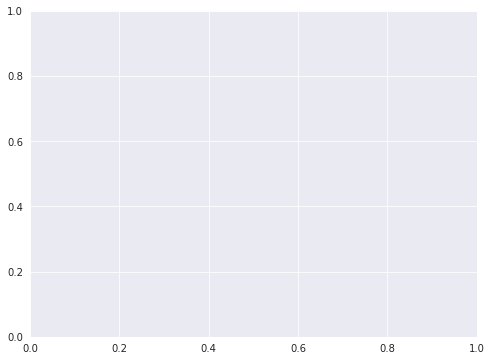

In [22]:
plot_difference(proof, 6, 'Results/', 'pdf')

In [34]:
def pairmsa(nuc1, nuc2):
        
    if nuc1[0] == nuc2[0]:
        
        return(np.nan)
        
    else:    
        
        seq1 = Seq(nuc1[1])
        seq2 = Seq(nuc2[1]) 

        aligner = Align.PairwiseAligner()
        #aligner.open_gap_score = -0.5
        #aligner.extend_gap_score = -0.1
        #aligner.target_end_gap_score = 0.0
        #aligner.query_end_gap_score = 0.0
        aligner.mode = 'global'

        alignment = aligner.align(seq1, seq2)[0]
        score = alignment.score/len(str(alignment).split('\n')[0])

        #alignments = pairwise2.align.globalxx(seq1, seq2, score_only = True) 

        return(score)


def worker(x, y, j, k, n, cl, gn):
           
    if n == -1:
        sample_x = cl.query('cluster == @j & centroid == True').join(gn)[['genome']].reset_index()
        sample_y = cl.query('cluster == @k & centroid == True').join(gn)[['genome']].reset_index()

    else:
        query_x = cl.query('cluster == @j').join(gn)[['genome']]
        if len(query_x) >= n:
            sample_x = query_x.sample(n=n).reset_index()
        else:
            sample_x = query_x.reset_index()

        query_y = cl.query('cluster == @k').join(gn)[['genome']]
        if len(query_y) >= n:
            sample_y = query_y.sample(n=n).reset_index()
        else:
            sample_y = query_y.reset_index()

    dist_mean = np.nanmean(ssd.cdist(sample_x, sample_y, metric = pairmsa))#.mean()
    #len_mean = (sample_x['genome'].str.len().mean() + sample_y['genome'].str.len().mean())/2

    #return((x,y,dist_mean/len_mean))
    return(x,y,dist_mean)


def sample_difference(cluster, genome, segment, proc = 8, n = 10):

    cl = cluster.query('segment == @segment') 
    gn = genome.loc[cl.index.values.tolist()]
    names = list(set(cl['cluster']).difference({-1}))
    num = len(names)
        
    params = []
    dist_matrix = np.empty([num, num])
    dist_matrix[:] = np.nan

    for x, j in enumerate(names):
        for y, k in enumerate(names[:names.index(j)+1]):
            params.append((x, y, j, k, n, cl, gn))

    with Pool(processes=proc) as pool:
        result = pool.starmap(worker, params)

    for x, y, dist in result:
        dist_matrix[x,y] = dist
        #dist_matrix[y,x] = dist
    
    dist_dataframe = pd.DataFrame(dist_matrix, index = names, columns = names)
    
    return(dist_dataframe)

In [43]:
sample_x = cluster.query('segment == 4 & cluster == 2').join(genome)[['genome']].sample(n=10, random_state=2).reset_index()
sample_y = cluster.query('segment == 4 & cluster == 2').join(genome)[['genome']].sample(n=10, random_state=2).reset_index()

In [45]:
ssd.cdist(sample_x, sample_y, metric = pairmsa).mean()

nan

In [47]:
np.array([1,2,3,4,5]).mean()

3.0

In [49]:
np.nanmean(np.array([1,2,np.nan,4,5]))

3.0

In [27]:
sample_x

,accession,genome
0,>CY116899,AGACAATGACTATCACTTTTCTCATCCTCCTATTCACAATAGTGAA...
1,>MK236924,GGTTATACCATAGACAACCGAACAAAGACAATGACTATCACTTTTC...
2,>CY139721,GGTTATACCATGGACAACCGAACAAAGACAATGACCATCACCTTTC...
3,>CY116979,GGTTATACCATGAACAACCAAACAAAGACAATGACTATCACTTTTC...
4,>MH501497,GGTTATACCATAGACAACCGAACAAAGACAATGACCATCACTTTTC...
5,>CY101555,GGTTATACCATGGACAACCGAACAAAGACAATGACTATCACTTTTC...
6,>FJ686754,GGTTATACCATGGACAACCAAACAAAGACAATGACTATCACTTTTC...
7,>CY045287,GACAATGACCATCATTTTTCTCATCCTCATGTTCACAGTAGTGAAA...
8,>CY202794,GGTTATACCATAGACAACCGAACAAAGAAAATGACCATCACTTTTC...
9,>LC042003,ATGACTATCACTTTTCTCATCCTCCTGTTCACAGTAGTGAAAGGGG...
